In [12]:
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob


# os.chdir("/capstor/scratch/cscs/ajayaraj/qtpyt-tests/gw_edmft/AuBDA14")

In [13]:
base_dir = "./"

# Find all site folders and sort them
site_dirs = sorted(glob(os.path.join(base_dir, "MaxEnt_Gdig_*_s1")))
n_sites = len(site_dirs)

# Read self-energy data
energies = None
sigma_real = []
sigma_imag = []

for d in site_dirs:
    # Find the Sdig file
    fname = glob(os.path.join(d, "Sdig*_s1.DAT_dos.dat"))[0]
    data = np.loadtxt(fname)

    E = data[:, 0]
    Re = data[:, 1]
    Im = data[:, 2]

    if energies is None:
        energies = E
    else:
        # Sanity check: energies must match
        if not np.allclose(energies, E):
            raise ValueError(f"Energy grid mismatch in {fname}")

    sigma_real.append(Re)
    sigma_imag.append(Im)

sigma_real = np.array(sigma_real)  # shape (8, nE)
sigma_imag = np.array(sigma_imag)  # shape (8, nE)

# Build self-energy matrices: one 8x8 matrix per energy
# Resulting shape: (nE, 8, 8)
sigma_matrices = np.zeros(
    (len(energies), n_sites, n_sites), dtype=np.complex128
)

for iE in range(len(energies)):
    diag = sigma_real[:, iE] + 1j * sigma_imag[:, iE]
    sigma_matrices[iE] = np.diag(diag)


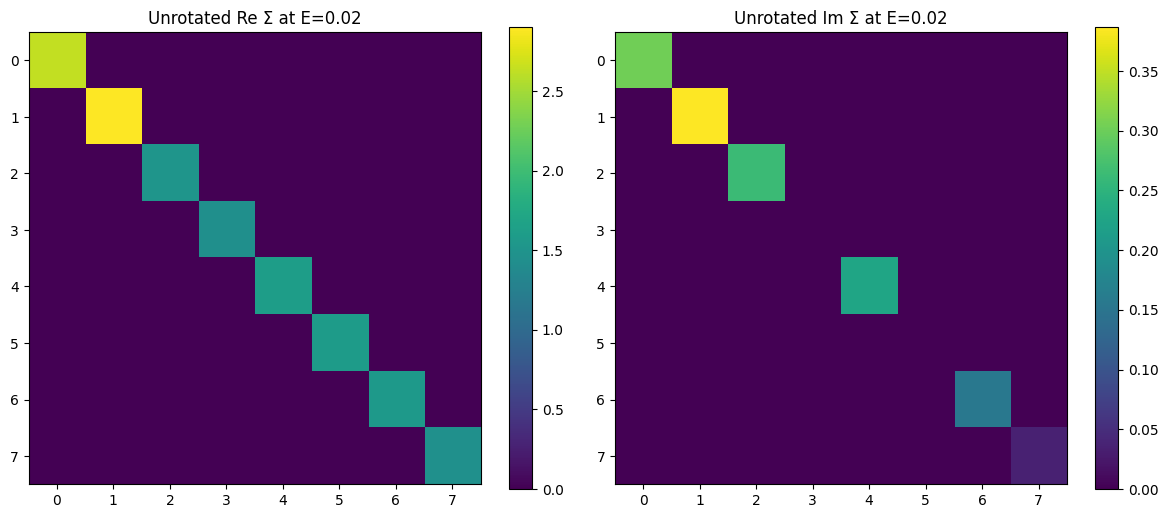

In [14]:
# Plot the real and imaginary parts of the self-energy matrices for iE = 0
iE = 3000
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.abs(sigma_matrices[iE].real), cmap="viridis")
plt.colorbar()
plt.title(f"Unrotated Re Σ at E={energies[iE]:.2f}")
plt.subplot(1, 2, 2)
plt.imshow(np.abs(sigma_matrices[iE].imag), cmap="viridis")
plt.colorbar()
plt.title(f"Unrotated Im Σ at E={energies[iE]:.2f}")
plt.tight_layout()
plt.show()

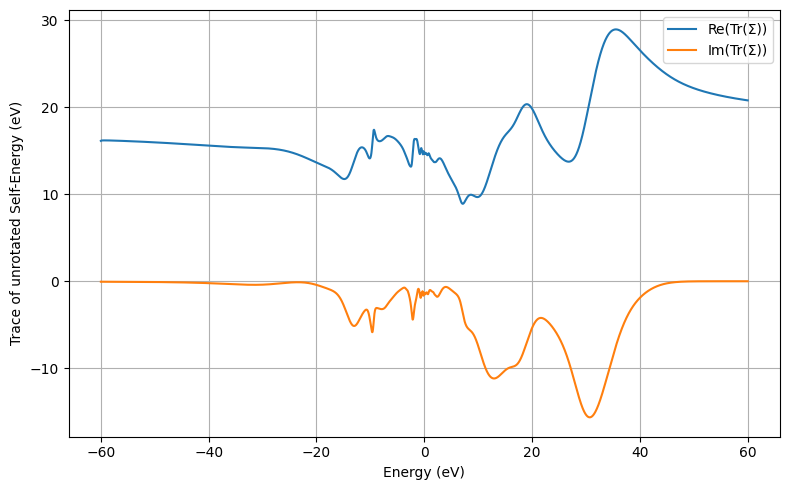

In [15]:
sigma_matrices_trace = np.trace(sigma_matrices, axis1=1, axis2=2)
# Plot the trace of the self-energy
plt.figure(figsize=(8, 5))
plt.plot(energies, sigma_matrices_trace.real, label="Re(Tr(Σ))")
plt.plot(energies, sigma_matrices_trace.imag, label="Im(Tr(Σ))")
plt.xlabel("Energy (eV)")
plt.ylabel("Trace of unrotated Self-Energy (eV)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [16]:
# Load rotation matrix
U = np.loadtxt(f"{base_dir}/ReHrot.DAT")

U_dag = U.conj().T

# Rotate self-energy at each energy
# sigma_matrices has shape (nE, 8, 8)
sigma_rot = np.empty_like(sigma_matrices)

for iE in range(len(energies)):
    sigma_rot[iE] = U @ sigma_matrices[iE] @ U_dag

# outputdir = "output/lowdin/gw_edmft"
# os.makedirs(outputdir, exist_ok=True)
# np.save(f"{outputdir}/self_energy_no_dcc.npy", sigma_rot)
# np.save(f"{outputdir}/energies.npy", energies)

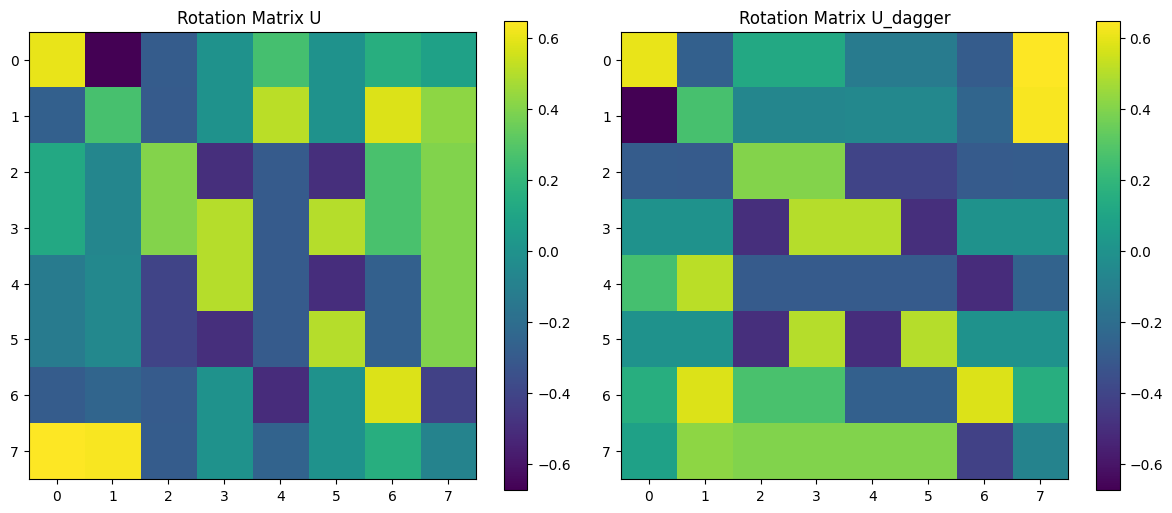

In [23]:
# Plot the rotation matrix U and U_dag side by side
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(U, cmap="viridis")
plt.colorbar()
plt.title("Rotation Matrix U ")
plt.subplot(1, 2, 2)
plt.imshow(U_dag, cmap="viridis")
plt.colorbar()
plt.title("Rotation Matrix U_dagger")
plt.tight_layout()
plt.show()

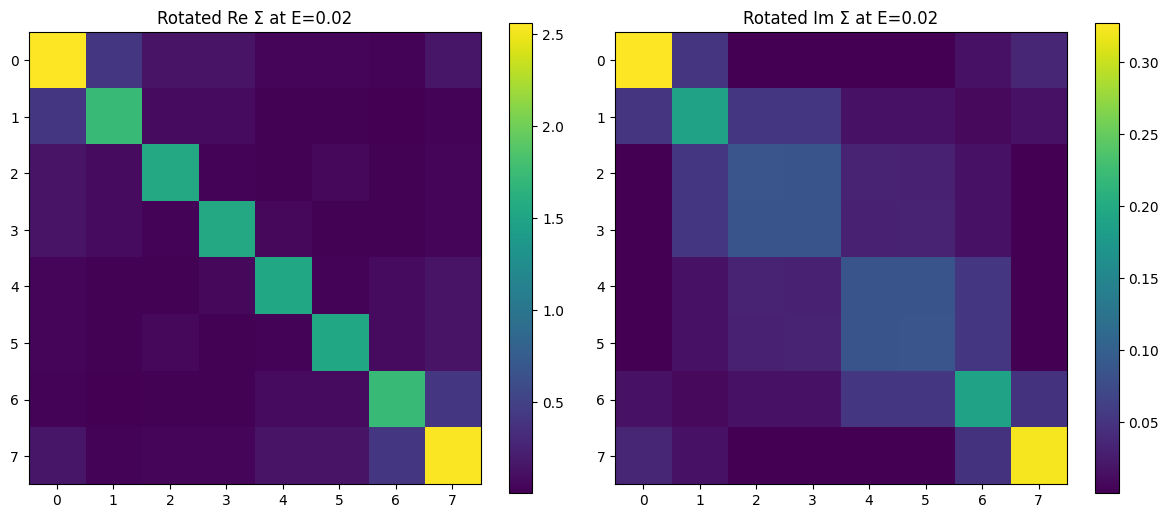

In [17]:
# Plot the real and imaginary parts of the rotated self-energy matrices for iE = 0
iE = 3000
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.abs(sigma_rot[iE].real), cmap="viridis")
plt.colorbar()
plt.title(f"Rotated Re Σ at E={energies[iE]:.2f}")
plt.subplot(1, 2, 2)
plt.imshow(np.abs(sigma_rot[iE].imag), cmap="viridis")
plt.colorbar()
plt.title(f"Rotated Im Σ at E={energies[iE]:.2f}")
plt.tight_layout()
plt.show()

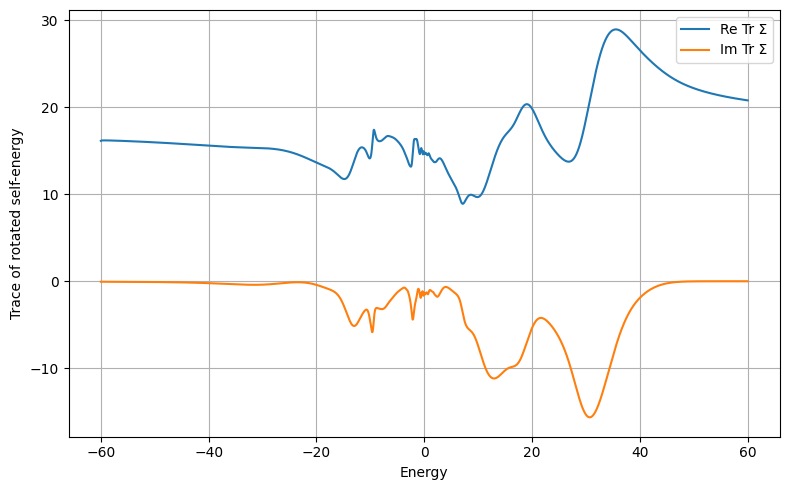

In [18]:
sigma_trace = np.trace(sigma_rot, axis1=1, axis2=2)

trace_real = sigma_trace.real
trace_imag = sigma_trace.imag

plt.figure(figsize=(8, 5))

plt.plot(energies, trace_real, label="Re Tr Σ")
plt.plot(energies, trace_imag, label="Im Tr Σ")

# plt.xlim(-3,3)
plt.xlabel("Energy")
plt.ylabel("Trace of rotated self-energy")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

shift = (trace_real[0]+trace_real[-1])/(2*n_sites)

sigma_rot.shape
sigma_rot = sigma_rot - np.eye(n_sites) * shift
# np.save(f"{outputdir}/self_energy_shifted.npy", sigma_rot)


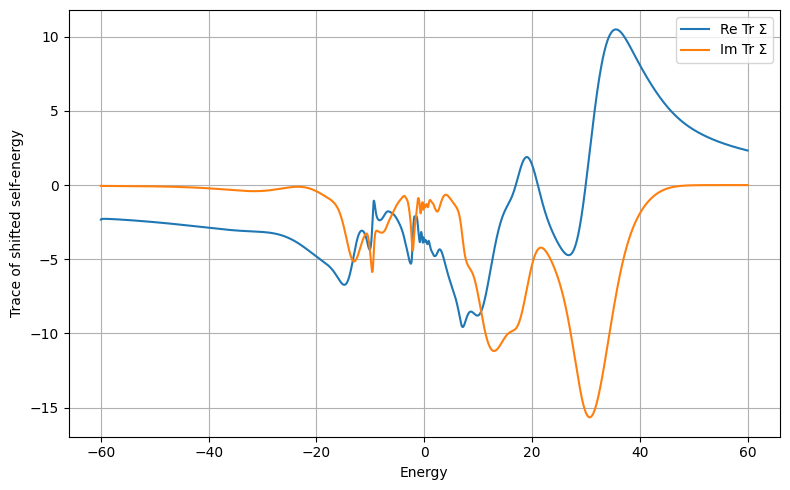

In [19]:
sigma_trace_shifted = np.trace(sigma_rot, axis1=1, axis2=2)

plt.figure(figsize=(8, 5))

plt.plot(energies, sigma_trace_shifted.real, label="Re Tr Σ")
plt.plot(energies, sigma_trace_shifted.imag, label="Im Tr Σ")

# plt.xlim(-3,3)
plt.xlabel("Energy")
plt.ylabel("Trace of shifted self-energy")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [20]:
sigma_trace_shifted.real[-1]

2.3287218181783746